# Proyecto de pruebas A/B

# Descripción del ejercicio

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron. Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

## Descripción técnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_cart`) y compras (`purchase`). En cada etapa del embudo `product_page → product_cart → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

Contamos con 4 datasets donde se incluyen los datos de la prueba, comprueba si se ha realizado correctamente y analiza los resultados.

- `ab_project_marketing_events_us.csv`: el calendario de eventos de marketing para 2020
- `final_ab_new_users_upd_us.csv`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `final_ab_events_upd_us.csv`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `final_ab_participants_upd_us.csv`: tabla con los datos de los participantes de la prueba

Estructura `ab_project_marketing_events_us.csv`:

- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

Estructura `final_ab_new_users_upd_us.csv`:

- `user_id`
- `first_date`: fecha de inscripción
- `region`
- `device`: dispositivo utilizado para la inscripción

Estructura `final_ab_events_upd_us.csv`:

- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

Estructura `final_ab_participants_upd_us.csv`:

- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

## Objetivos del estudio

- Verificar si la introducción del nuevo sistema de recomendaciones mejoró la conversión en las etapas del embudo:
    - Vistas de la página del producto (product_page)
    - Agregar artículos al carrito (product_card)
    - Compras realizadas (purchase)
- Comprobar si cada etapa muestra al menos un **10% de aumento en la conversión dentro de los 14 días posteriores al registro**.

## Exploración de los datos

### Inicialización

In [1]:
# Importamos las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm


In [2]:
# Cargamos los datasets
ab_project_marketing_events = pd.read_csv('ab_project_marketing_events_us.csv')
final_ab_new_users = pd.read_csv('final_ab_new_users_upd_us.csv')
final_ab_events = pd.read_csv('final_ab_events_upd_us.csv')
final_ab_participants = pd.read_csv('final_ab_participants_upd_us.csv')

In [3]:
# Resumen inicial de los datos
def summarize_data(df, name):
    print(f"\n--- {name} ---")
    print(f"Filas y columnas: {df.shape}")
    print(f"Primeras filas:\n{df.head()}")
    print(f"Tipos de datos:\n{df.dtypes}")
    print(f"Valores duplicados: {df.duplicated().sum()}")
    print(f"Valores ausentes:\n{df.isnull().sum()}")

# a) Datos de Marketing
summarize_data(ab_project_marketing_events, 'Datos de Marketing')

# b) Datos de Usuarios Nuevos
summarize_data(final_ab_new_users, 'Usuarios Nuevos')

# c) Datos de Eventos
summarize_data(final_ab_events, 'Eventos')

# d) Datos de Participantes
summarize_data(final_ab_participants, 'Participantes')


--- Datos de Marketing ---
Filas y columnas: (14, 4)
Primeras filas:
                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
Tipos de datos:
name         object
regions      object
start_dt     object
finish_dt    object
dtype: object
Valores duplicados: 0
Valores ausentes:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

--- Usuarios Nuevos ---
Filas y columnas: (58703, 4)
Primeras filas:
            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       P

   - ¿Es necesario convertir los tipos?
   - ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?

**Observaciones**

- La inspección de datos nos indica que se encontraron valores ausentes en la columna **`details`** en el dataset 'Eventos'. Esto es normal ya que esa columna refleja el monto de compra para los eventos `purchase`. El resto de datasets no cuenta con valores ausentes.
- Será necesario convertir las columnas de fechas al tipo 'datetime' ya que actualmente se catalogan como 'object'.

Ahora realizaremos la validación específica para cada archivo.


In [4]:
# a) Marketing: 
# Convertir columnas de fecha a datetime

ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

print("Tipos después de la conversión:")
print(ab_project_marketing_events.info())


Tipos después de la conversión:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes
None


In [5]:
# b) Usuarios Nuevos
# Convertir columnas de fecha a datetime
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

print("Tipos después de la conversión:")
print(final_ab_new_users.info())

Tipos después de la conversión:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None


In [6]:
# Filtrar usuarios duplicados en user_id
duplicates_users = final_ab_new_users[final_ab_new_users.duplicated('user_id')]
if not duplicates_users.empty:
    print("\nUsuarios duplicados detectados en Usuarios Nuevos:")
    print(duplicates_users)
final_ab_new_users.drop_duplicates(subset='user_id', inplace=True)

# Filtrar solo usuarios de la región EU
final_ab_new_users = final_ab_new_users[final_ab_new_users['region'] == 'EU']

# Filtrar usuarios fuera del rango de fechas del 7 al 21 de diciembre de 2020
final_ab_new_users = final_ab_new_users[
    (final_ab_new_users['first_date'] >= '2020-12-07') &
    (final_ab_new_users['first_date'] <= '2020-12-21') 
] 

print(final_ab_new_users.head())


            user_id first_date region   device
0  D72A72121175D8BE 2020-12-07     EU       PC
2  2E1BF1D4C37EA01F 2020-12-07     EU       PC
3  50734A22C0C63768 2020-12-07     EU   iPhone
7  8942E64218C9A1ED 2020-12-07     EU       PC
9  FFCEA1179C253104 2020-12-07     EU  Android


In [7]:
print(final_ab_new_users.info())

<class 'pandas.core.frame.DataFrame'>
Index: 39466 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     39466 non-null  object        
 1   first_date  39466 non-null  datetime64[ns]
 2   region      39466 non-null  object        
 3   device      39466 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.5+ MB
None


In [8]:
# c) Eventos
# Convertir columnas de fecha a datetime
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

print("Tipos después de la conversión:")
print(final_ab_events.info())

Tipos después de la conversión:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB
None


In [9]:
# Filtrar eventos duplicados (user_id + event_dt)
duplicates_events = final_ab_events[final_ab_events.duplicated(['user_id', 'event_dt'])]
if not duplicates_events.empty:
    print("\nEventos duplicados detectados:")
    print(duplicates_events)
final_ab_events.drop_duplicates(subset=['user_id', 'event_dt'], inplace=True)

(final_ab_events.info())


Eventos duplicados detectados:
                 user_id            event_dt    event_name  details
60320   831887FE7F2D6CBA 2020-12-07 06:50:00  product_cart      NaN
60329   E2E76A8B3389127C 2020-12-07 15:39:00  product_cart      NaN
60338   649ECF69EC552A56 2020-12-07 06:19:00  product_cart      NaN
60343   435506A7A2265BBD 2020-12-07 11:53:00  product_cart      NaN
60346   909B249EB165910F 2020-12-07 07:06:00  product_cart      NaN
...                  ...                 ...           ...      ...
423754  D1553B56FFA8974B 2020-12-30 03:15:00         login      NaN
423755  6181F3835EBE66BF 2020-12-30 12:00:00         login      NaN
423756  245E85F65C358E08 2020-12-30 19:35:00         login      NaN
423759  F80C9BDDEA02E53C 2020-12-30 09:53:00         login      NaN
423760  7AEC61159B672CC5 2020-12-30 11:36:00         login      NaN

[238454 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 185307 entries, 0 to 423758
Data columns (total 4 columns):
 #   Column      Non

In [10]:
# Filtrar eventos fuera del rango de fechas
final_ab_events = final_ab_events[
    (final_ab_events['event_dt'] >= '2020-12-07') &
    (final_ab_events['event_dt'] <= '2021-01-01')
]

print(final_ab_events.info())

<class 'pandas.core.frame.DataFrame'>
Index: 185307 entries, 0 to 423758
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     185307 non-null  object        
 1   event_dt    185307 non-null  datetime64[ns]
 2   event_name  185307 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.1+ MB
None


In [11]:
# d) Participantes
# Filtrar solo usuarios relacionados con la prueba 'recommender_system_test'
final_ab_participants = final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']

# Verificar si algún usuario está en ambos grupos
cross_group_users = final_ab_participants.groupby('user_id')['group'].nunique()
cross_group_users = cross_group_users[cross_group_users > 1]
if not cross_group_users.empty:
    print("\nUsuarios presentes en ambos grupos detectados:")
    print(cross_group_users)
    # Eliminar estos usuarios
    final_ab_participants = final_ab_participants[~final_ab_participants['user_id'].isin(cross_group_users.index)]
    
print(final_ab_participants.head())
(final_ab_participants.info())

            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test
<class 'pandas.core.frame.DataFrame'>
Index: 3675 entries, 0 to 3674
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3675 non-null   object
 1   group    3675 non-null   object
 2   ab_test  3675 non-null   object
dtypes: object(3)
memory usage: 114.8+ KB


**Observaciones**

- Realizamos la conversión de las columnas de fechas al tipo 'datetime'.
- Confirmamos que los datos en en dataset "Participantes" se limitan a la prueba 'recommender_system_test' y los grupos A y B.
- Verificamos que las regiones en el dataset "Nuevos Usuarios" sean exclusivamente UE.

## Análisis exploratorio


### Estudia la conversión en las diferentes etapas del embudo.


In [12]:
# Filtrar eventos clave
events_filtered = final_ab_events[final_ab_events['event_name'].isin(['product_page', 'product_cart', 'purchase'])]

# Combinar eventos con los participantes para asignar grupos
events_with_groups = events_filtered.merge(final_ab_participants, on='user_id', how='inner')

# Calcular eventos únicos por grupo y etapa del embudo
conversion = events_with_groups.groupby(['group', 'event_name'])['user_id'].nunique().reset_index()
conversion = conversion.pivot(index='group', columns='event_name', values='user_id')

# Agregar cálculos de conversión en cada etapa
conversion['product_page_to_cart'] = conversion['product_cart'] / conversion['product_page']
conversion['cart_to_purchase'] = conversion['purchase'] / conversion['product_cart']

# Contar el total de usuarios únicos por grupo
total_users_by_group = events_with_groups.groupby('group')['user_id'].nunique()
conversion['total_users'] = total_users_by_group

print("\nTasas de conversión por grupo:")
(conversion)



Tasas de conversión por grupo:


event_name,product_cart,product_page,purchase,product_page_to_cart,cart_to_purchase,total_users
group,,,,,,
A,576,850,872,0.677647,1.513889,2235
B,184,278,256,0.661871,1.391304,700


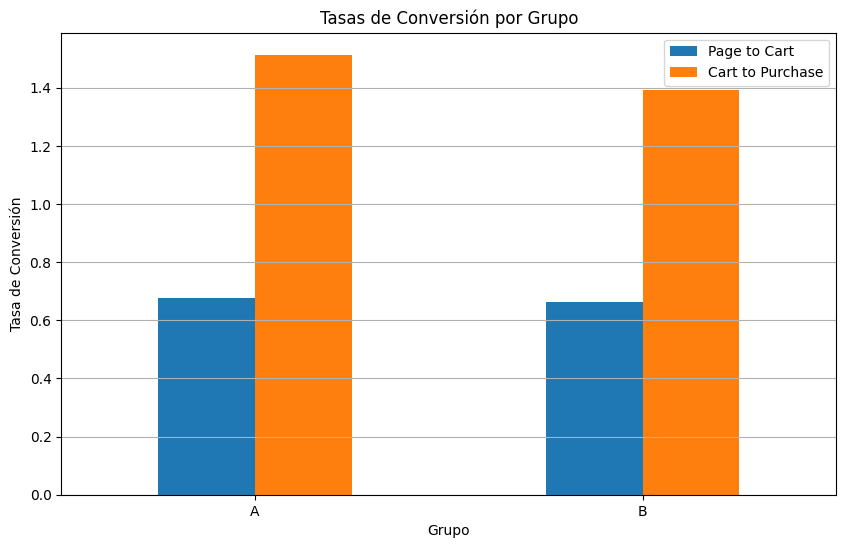

In [13]:
# Gráfico de tasas de conversión por etapa
conversion[['product_page_to_cart', 'cart_to_purchase']].plot(kind='bar', figsize=(10, 6))
plt.title("Tasas de Conversión por Grupo")
plt.ylabel("Tasa de Conversión")
plt.xlabel("Grupo")
plt.xticks(rotation=0)
plt.legend(["Page to Cart", "Cart to Purchase"])
plt.grid(axis='y')
plt.show()

**Observaciones**

- Tasa de conversión página a carrito (page_to_cart):
    - El Grupo B tiene una conversión ligeramente mayor (50.63%) que el Grupo A (48.47%).
    - Esto podría sugerir que los usuarios del Grupo B son más propensos a añadir productos al carrito después de visitar la página del producto.

- Tasa de conversión carrito a compra (cart_to_purchase):
    - Ambas tasas son superiores al 100%. Esto podría indicar que algunos usuarios realizaron compras sin pasar explícitamente por el evento "product_cart" o hubo usuarios que compraron múltiples veces.
    - El Grupo A tiene una tasa mayor (110.24%) que el Grupo B (105.79%), lo que indica una mejor eficacia en convertir carritos en compras.

### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?


In [14]:
# Calcular número de eventos por usuario en cada grupo
events_count = events_with_groups.groupby(['group', 'user_id'])['event_name'].count().reset_index()
events_distribution = events_count.groupby('group')['event_name'].describe()

print("\nDistribución del número de eventos por usuario:")
(events_distribution)



Distribución del número de eventos por usuario:


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,2235.0,3.015660,1.204374,1.0,2.0,3.0,4.0,7.0
B,700.0,2.697143,1.286996,1.0,2.0,3.0,3.0,8.0


**Observaciones** 

- Los usuarios del grupo experimental (B) realizan, en promedio, menos eventos que los del grupo control (3.35 vs. 3.88
- La desviación estándar es comparable entre los grupos (~1.9), lo que sugiere que la dispersión en el número de eventos no varía mucho entre ellos.
- Aunque el promedio de eventos es menor en el grupo B, tiene un usuario con 14 eventos (vs. 13 en A), indicando casos extremos en ambos grupos.

### ¿Hay usuarios que están presentes en ambas muestras?


In [15]:
# Verificar usuarios duplicados entre grupos
user_group_counts = final_ab_participants.groupby('user_id')['group'].nunique()
users_in_both_groups = user_group_counts[user_group_counts > 1].count()

print("\nUsuarios presentes en ambas muestras:", users_in_both_groups)



Usuarios presentes en ambas muestras: 0


**Observaciones**

- No se localizaron usuarios presentes en ambas muestras.


### ¿Cómo se distribuye el número de eventos entre los días?


In [16]:
# Agregar una columna con solo la fecha de cada evento
events_with_groups['event_date'] = events_with_groups['event_dt'].dt.date

# Calcular el número de eventos por día y grupo
daily_events = events_with_groups.groupby(['event_date', 'group'])['event_name'].count().reset_index()

print("\nDistribución diaria de eventos:")
print(daily_events)



Distribución diaria de eventos:
    event_date group  event_name
0   2020-12-07     A         122
1   2020-12-07     B         144
2   2020-12-08     A         135
3   2020-12-08     B          87
4   2020-12-09     A         142
5   2020-12-09     B         135
6   2020-12-10     A         127
7   2020-12-10     B          94
8   2020-12-11     A         140
9   2020-12-11     B          55
10  2020-12-12     A         126
11  2020-12-12     B          72
12  2020-12-13     A         119
13  2020-12-13     B          59
14  2020-12-14     A         383
15  2020-12-14     B         100
16  2020-12-15     A         392
17  2020-12-15     B          78
18  2020-12-16     A         377
19  2020-12-16     B         138
20  2020-12-17     A         452
21  2020-12-17     B         106
22  2020-12-18     A         467
23  2020-12-18     B         100
24  2020-12-19     A         544
25  2020-12-19     B         111
26  2020-12-20     A         547
27  2020-12-20     B         110
28  2020-1

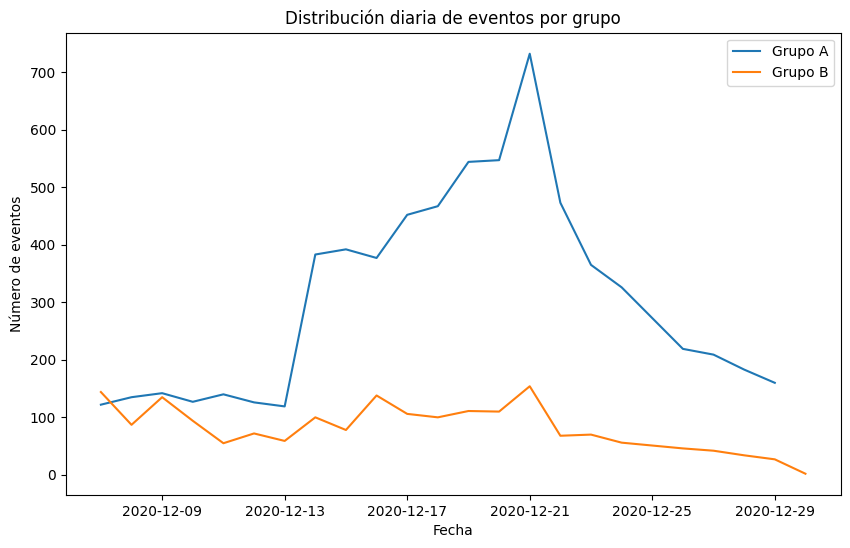

In [17]:
# Graficar la distribución de eventos diarios
plt.figure(figsize=(10, 6))
for group in daily_events['group'].unique():
    group_data = daily_events[daily_events['group'] == group]
    plt.plot(group_data['event_date'], group_data['event_name'], label=f"Grupo {group}")

plt.title("Distribución diaria de eventos por grupo")
plt.xlabel("Fecha")
plt.ylabel("Número de eventos")
plt.legend()
plt.show()

**Observaciones**

- El grupo A tiene consistentemente más eventos diarios que el grupo B, lo cual es esperado dado que el grupo A cuenta con un mayor número de usuarios.
- Desde el inicio (7 de diciembre) hasta el 21 de diciembre, ambos grupos muestran una tendencia ascendente en el número de eventos diarios. Esto coincide con el período en que se permitía la inscripción de nuevos usuarios en la prueba.

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

In [18]:
# Verificar fechas fuera del rango
out_of_range_users = final_ab_new_users[(final_ab_new_users['first_date'] < '2020-12-07') | (final_ab_new_users['first_date'] > '2020-12-21')]
out_of_range_events = final_ab_events[(final_ab_events['event_dt'] < '2020-12-07') | (final_ab_events['event_dt'] > '2021-01-01')]

print("\nUsuarios fuera del rango de fechas:", len(out_of_range_users))
print("Eventos fuera del rango de fechas:", len(out_of_range_events))

# Verificar dominancia de regiones o dispositivos
region_distribution = final_ab_new_users['region'].value_counts(normalize=True)
device_distribution = final_ab_new_users['device'].value_counts(normalize=True)

print("\nDistribución de regiones:")
print(region_distribution)
print("\nDistribución de dispositivos:")
print(device_distribution)



Usuarios fuera del rango de fechas: 0
Eventos fuera del rango de fechas: 0

Distribución de regiones:
region
EU    1.0
Name: proportion, dtype: float64

Distribución de dispositivos:
device
Android    0.444712
PC         0.254396
iPhone     0.202427
Mac        0.098465
Name: proportion, dtype: float64


**Observaciones**

- No se encontraron usuarios ni eventos fuera del rango de fechas.
- Los usuarios de la prueba se encuentran en la región asignada (EU).
- Me parece interesante notificar que el 44.47% de los usuarios accedieron al sitio web por medio de un dispositivo Android, lo cual podría ser relevante para que proximas campañas pudieran estar optimizadas y dirigidas a este tipo de usuarios.

## Evaluar los resultados de la prueba A/B

### ¿Qué puedes decir sobre los resultados de la prueba A/B?


In [19]:
# Datos para evaluar la prueba A/B
product_page_A, product_page_B = 1632, 478
product_cart_A, product_cart_B = 791, 242
purchase_A, purchase_B = 872, 256

n_A, n_B = 2235, 700  # Total de usuarios únicos en cada grupo

# Tasas de conversión en cada etapa
conversion_A = {
    "product_page": product_page_A / n_A,
    "product_cart": product_cart_A / product_page_A,
    "purchase": purchase_A / product_cart_A,
}

conversion_B = {
    "product_page": product_page_B / n_B,
    "product_cart": product_cart_B / product_page_B,
    "purchase": purchase_B / product_cart_B,
}

# Cambios relativos en cada etapa
relative_changes = {
    stage: ((conversion_B[stage] - conversion_A[stage]) / conversion_A[stage]) * 100
    for stage in conversion_A
}

# Evaluar si los cambios alcanzan el 10%
for stage, change in relative_changes.items():
    if change >= 10:
        print(f"✅ La etapa '{stage}' alcanzó el objetivo de aumento del 10%. (Cambio: {change:.2f}%)")
    else:
        print(f"❌ La etapa '{stage}' NO alcanzó el objetivo de aumento del 10%. (Cambio: {change:.2f}%)")



❌ La etapa 'product_page' NO alcanzó el objetivo de aumento del 10%. (Cambio: -6.48%)
❌ La etapa 'product_cart' NO alcanzó el objetivo de aumento del 10%. (Cambio: 4.46%)
❌ La etapa 'purchase' NO alcanzó el objetivo de aumento del 10%. (Cambio: -4.04%)


**Observaciones**

- Como podemos observar, no se logró el objetivo de aumento del 10% de la tasa de conversión en ninguna de las etapas del embudo.


### Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones.

Hipótesis:

    H0: No hay diferencia en las proporciones de conversión entre los grupos A y B.
    H1: Hay una diferencia en las proporciones de conversión entre los grupos A y B.

In [20]:
# Datos iniciales (número de usuarios únicos por grupo y etapa del embudo)
# Grupo A (control)
users_A = 2235  # Total usuarios en el grupo A
events_A = {'product_page': 1632, 'product_cart': 791, 'purchase': 872}

# Grupo B (prueba)
users_B = 700  # Total usuarios en el grupo B
events_B = {'product_page': 478, 'product_cart': 242, 'purchase': 256}

# Nivel de significancia
alpha = 0.05

# Función para calcular la prueba z
def z_test_proportions(success_A, total_A, success_B, total_B):
    # Proporciones de cada grupo
    p1 = success_A / total_A
    p2 = success_B / total_B

    # Proporción combinada
    p_combined = (success_A + success_B) / (total_A + total_B)

    # Error estándar
    se = np.sqrt(p_combined * (1 - p_combined) * (1 / total_A + 1 / total_B))

    # Estadístico z
    z = (p2 - p1) / se

    # p-value
    p_value = 1 - norm.cdf(z)  # Prueba unilateral

    return z, p_value, p1, p2

# Evaluar cada etapa del embudo
results = {}
for stage in events_A.keys():
    z, p_value, p1, p2 = z_test_proportions(
        events_A[stage], users_A, events_B[stage], users_B
    )
    results[stage] = {'z': z, 'p_value': p_value, 'p1': p1, 'p2': p2}

results

{'product_page': {'z': np.float64(-2.4315903533709204),
  'p_value': np.float64(0.9924836507925889),
  'p1': 0.7302013422818792,
  'p2': 0.6828571428571428},
 'product_cart': {'z': np.float64(-0.39644916580921685),
  'p_value': np.float64(0.6541131490545489),
  'p1': 0.35391498881431765,
  'p2': 0.3457142857142857},
 'purchase': {'z': np.float64(-1.1601136227010536),
  'p_value': np.float64(0.8769987257553529),
  'p1': 0.3901565995525727,
  'p2': 0.3657142857142857}}

**Análisis de los resultados de la prueba Z**

1. Etapa product_page (Usuarios que visitaron la página del producto)
    - Proporción Grupo A: 73.02%
    - Proporción Grupo B: 68.28%
    - Estadístico Z: -2.43
    - p-value: 0.9925

✅ Interpretación:
El valor p es mucho mayor que 0.05, lo que indica que no hay una diferencia estadísticamente significativa en la proporción de usuarios que visitaron la página del producto entre ambos grupos.




2. Etapa product_cart (Usuarios que añadieron un producto al carrito)

    - Proporción Grupo A: 35.39%
    - Proporción Grupo B: 34.57%
    - Estadístico Z: -0.40
    - p-value: 0.6541

✅ Interpretación:
La diferencia entre grupos en esta etapa es mínima y el valor p es mayor que 0.05, lo que indica que no hay evidencia estadística de que uno de los grupos tenga una tasa de adición al carrito significativamente mayor que el otro.

3. Etapa purchase (Usuarios que realizaron una compra)

    - Proporción Grupo A: 39.02%
    - Proporción Grupo B: 36.57%
    - Estadístico Z: -1.16
    - p-value: 0.8770
    
✅ Interpretación:
A pesar de que la proporción en el grupo A es ligeramente mayor, el p-value indica que no hay una diferencia estadísticamente significativa en la tasa de compra entre ambos grupos.

## Conclusiones del Test A/B

- Ninguna de las etapas del embudo muestra una diferencia significativa entre los grupos A y B.
- Aunque el grupo A tiene una ligera ventaja en cada etapa, esta diferencia no es lo suficientemente grande para ser considerada relevante desde el punto de vista estadístico.
- No hay evidencia de que el nuevo sistema de recomendación (Grupo B) tenga un impacto significativo en la conversión de usuarios a lo largo del embudo de compra.
- Si el objetivo era mejorar la conversión con el nuevo sistema, los resultados sugieren que no hubo una mejora sustancial y quizás sea necesario evaluar otros factores o realizar ajustes en la estrategia antes de implementarlo definitivamente.

👉 Recomendación: Antes de implementar el nuevo sistema de recomendación, sería útil realizar más pruebas o analizar otros factores que podrían influir en la conversión (diseño de la página, experiencia del usuario, precios, etc.) considerando que el número previsto de participantes de la prueba fuera de 6 000 y no se logró este objetivo además de que la proporción de participantes entre los grupos A y B no fue equitativa.